# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

There are 17 marketing campaigns collected between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [2]:
# Load and show data/bank-additional-full.csv
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Data Cleaning / Pre-processing

1. Remove duration since it will not help in the predictive model. Also, the duration is not known before a call so can't be used for the prediction.
2. Convert following fields to numeric using one hot:
job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome
3. Instead of using 999 in pdays for client not previously contacted, change it to 0 instead.
4. Normalize numeric fields:
age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

In [5]:
# Drop duration column and assign it to df
df = df.drop(columns = 'duration')

# Convert 999 in pdays to 0
df['pdays'] = df['pdays'].replace(999, 0)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective: Identify the best classification model that will accurately predict the conditions/features of a successful marketing campaign. What are the client, marketing campaign, and socio economic features that will provide the best chance of making the client sign up after the campaign.

In [6]:
# check for NaN values    
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# Set color scheme for seaborn
#sns.set_palette("bright")

##### Bank Client Data Analysis

Text(0.5, 1.0, 'Housing distribution')

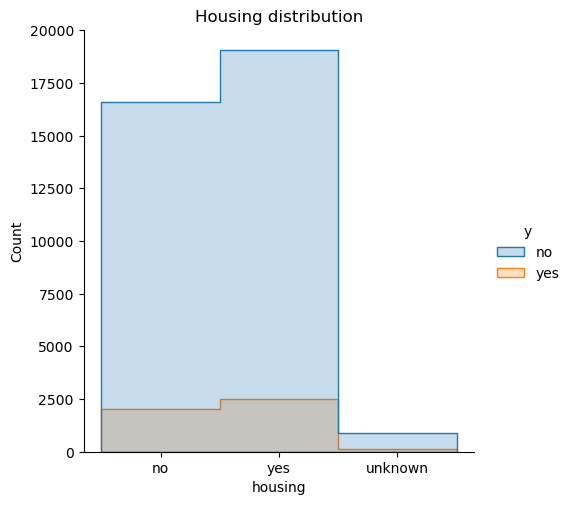

In [8]:
sns.displot(df, x="housing", hue="y", bins = 5, element="step")
plt.title('Housing distribution')

Text(0.5, 1.0, 'Campaign distribution')

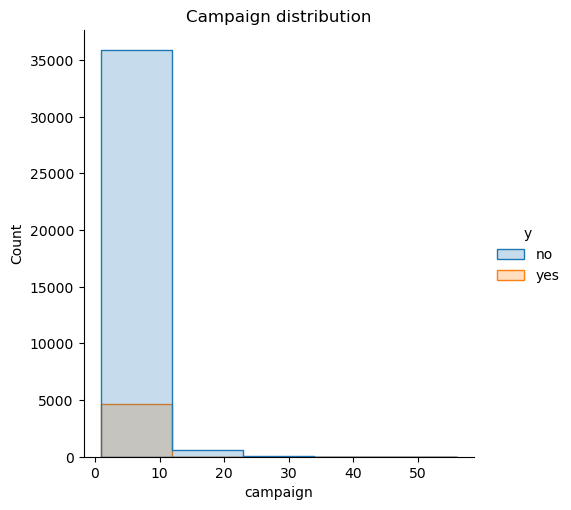

In [9]:
sns.displot(df, x="campaign", hue="y", bins = 5, element="step")
plt.title('Campaign distribution')

Text(0.5, 1.0, 'Age distribution')

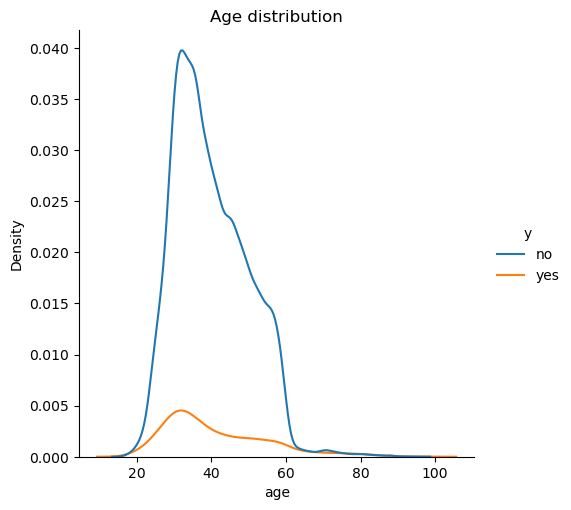

In [10]:
# distribution of age
sns.displot(df, x="age", hue="y", kind="kde")
plt.title('Age distribution')

Text(0.5, 1.0, 'Marital distribution')

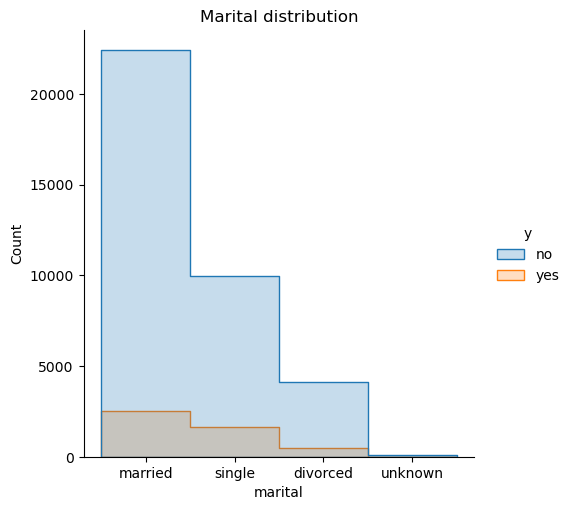

In [11]:
# distribution of marital
sns.displot(df, x="marital", hue="y", bins = 20, element="step")
plt.title('Marital distribution')

Text(0.5, 1.0, 'Default distribution')

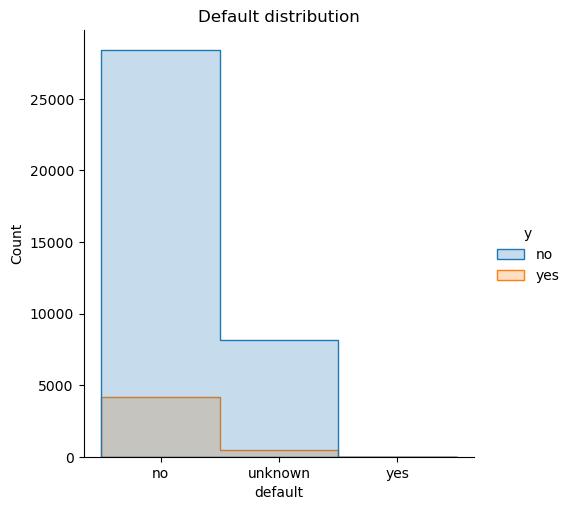

In [12]:
#sns.displot(df, x="default", hue="y", bins = 20)

sns.displot(df, x="default", hue="y", bins = 20, element="step")
plt.title('Default distribution')

Text(0.5, 1.0, 'Loan distribution')

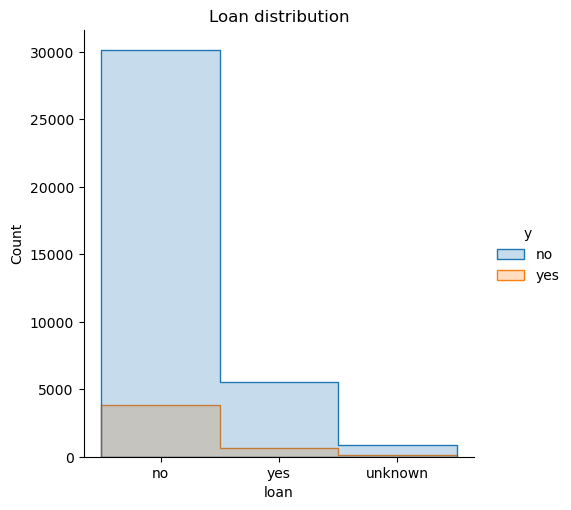

In [13]:
sns.displot(df, x="loan", hue="y", bins = 20, element="step")
plt.title('Loan distribution')


In [14]:
# check value_counts for non numeric columns
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
for column in non_numeric_columns:
    print(df[column].value_counts())

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64
contact
cellular     26144
telephone    15044
Name: count, dtype: in

##### Previous Contact Analysis

Text(0.5, 1.0, 'Poutcome distribution')

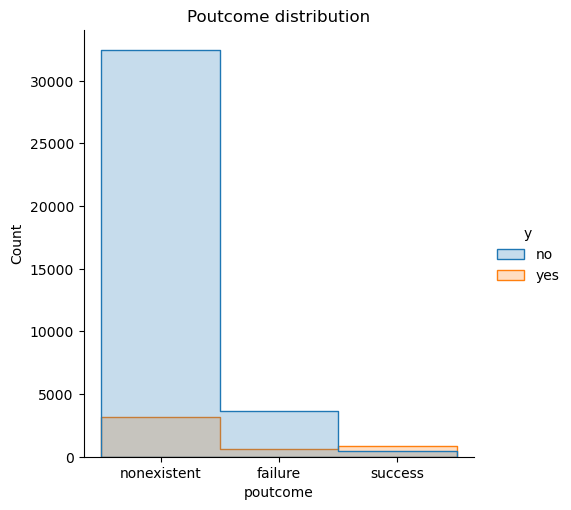

In [15]:
sns.displot(df, x="poutcome", hue="y", bins = 20, element="step")
plt.title('Poutcome distribution')


Text(0.5, 1.0, 'Contact distribution')

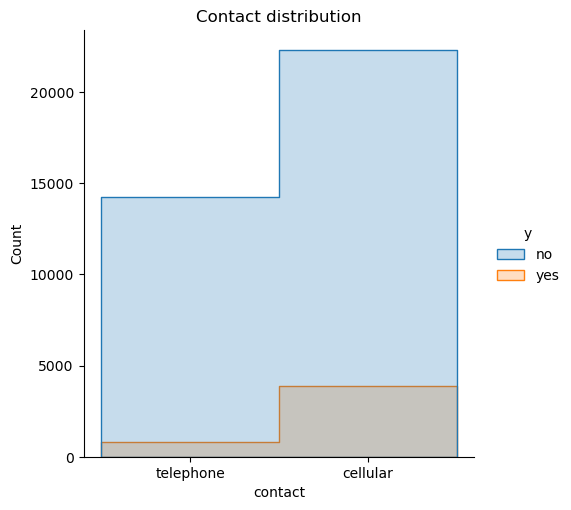

In [16]:
sns.displot(df, x="contact", hue="y", bins = 20, element="step")
plt.title('Contact distribution')


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [17]:
# Use make_column_selector to select non-numeric columns
selector = ''

selector = make_column_selector(dtype_include=object)

In [18]:
# Using make_column_transformer to apply OneHotEncoder to non-numeric columns and StandardScaler to numeric columns
transformer = ''

transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())

In [19]:
# Feature extraction
extractor = ''

extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

In [20]:
# Pipeline
lgr_pipe = ''
lgr_pipe_trainscore = ''
lgr_pipe_testscore = ''

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression())], verbose=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis = 1), df['y'], random_state = 442,
                                                   stratify = df['y'])

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Based on the material, the positive response for a mass marketing campaign is less than 1%.

In [22]:
# use DummyClassifier to get the baseline score

dummy_clf = ''
baseline_score = ''

dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)

print('Baseline Score ==> ' + str(baseline_score))


Baseline Score ==> 0.8873458288821987


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [23]:
# Using Logistic Regression with default parameters
start_time = time.time()
lgr_pipe.fit(X_train, y_train)
lgr_time = time.time() - start_time

print('LGR Train Time (sec) ==> ' + str(lgr_time))


[Pipeline] ....... (step 1 of 3) Processing transformer, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.1s
[Pipeline] ............... (step 3 of 3) Processing lgr, total=   0.2s
LGR Train Time (sec) ==> 1.3641633987426758


### Problem 9: Score the Model

What is the accuracy of your model?

In [24]:
# LGR train score
lgr_pipe_trainscore = lgr_pipe.score(X_train, y_train)

print('LGR Train Score ==> ' + str(lgr_pipe_trainscore))

# LGR test score
lgr_pipe_testscore = lgr_pipe.score(X_test, y_test)

print('LGR Test Score ==> ' + str(lgr_pipe_testscore))

LGR Train Score ==> 0.9002298404065909
LGR Test Score ==> 0.8964747013693308


False Positives ==> 144
False Negatives ==> 922
AUC ==> 0.78
Precision ==> 0.6230366492146597
Accuracy ==> 0.8964747013693308


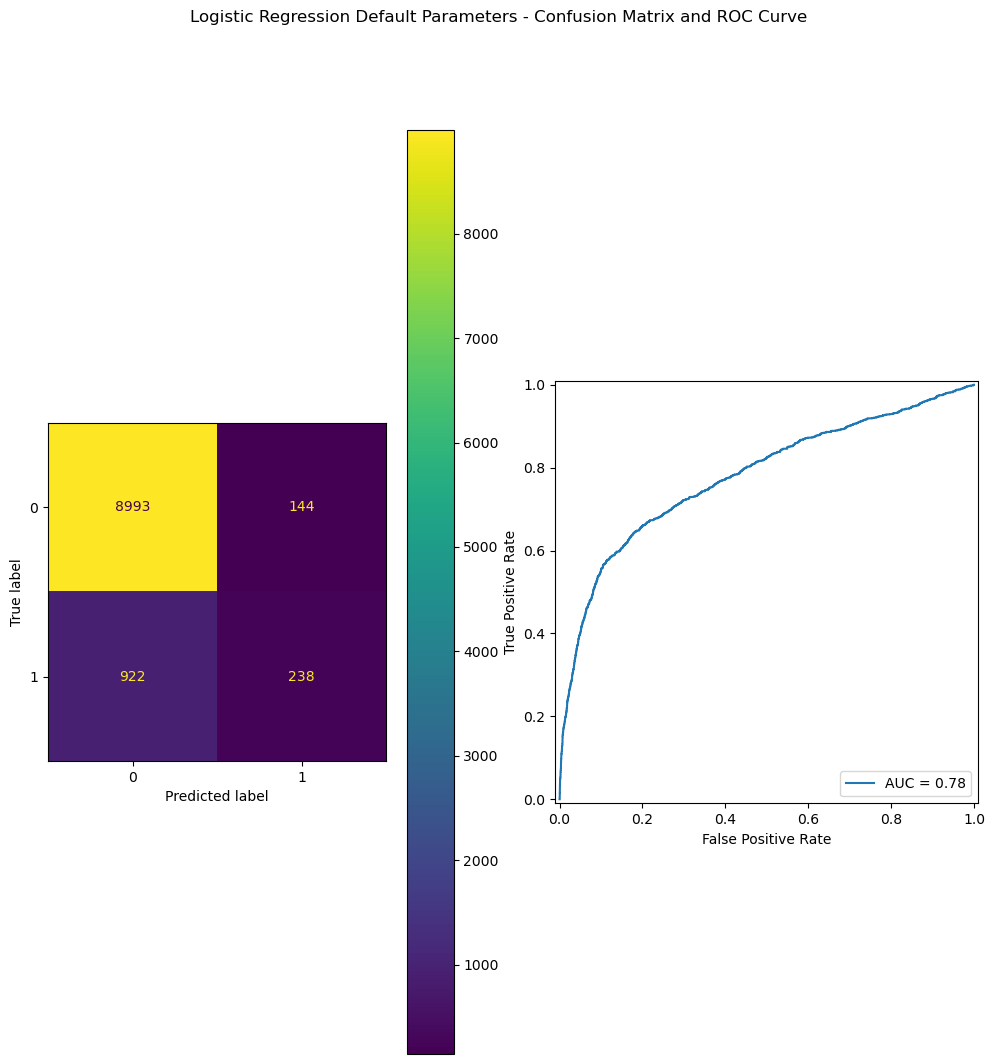

In [25]:
### LGR Default Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
lgr_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = lgr_pipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
lgr_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('Logistic Regression Default Parameters - Confusion Matrix and ROC Curve')


fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(lgr_precision))
print('Accuracy ==> ' + str(accuracy))



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [26]:
# Using KNN with default parameters
knnpipe = ''
knnpipe_trainscore = ''
knnpipe_testscore = ''

knnpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier())], verbose=True)

start_time = time.time()
knnpipe.fit(X_train, y_train)
knn_time = time.time() - start_time

print('KNN Train Time (sec) ==> ' + str(knn_time))

knnpipe_trainscore = knnpipe.score(X_train, y_train)
print('KNN Train Score ==> ' + str(knnpipe_trainscore))

knnpipe_testscore = knnpipe.score(X_test, y_test)
print('KNN Test Score ==> ' + str(knnpipe_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.0s
[Pipeline] ............... (step 3 of 3) Processing knn, total=   0.0s
KNN Train Time (sec) ==> 1.1324329376220703
KNN Train Score ==> 0.9140526366902981
KNN Test Score ==> 0.8870544818879286


False Positives ==> 307
False Negatives ==> 856
AUC ==> 0.72
Precision ==> 0.49754500818330605
Accuracy ==> 0.8870544818879286


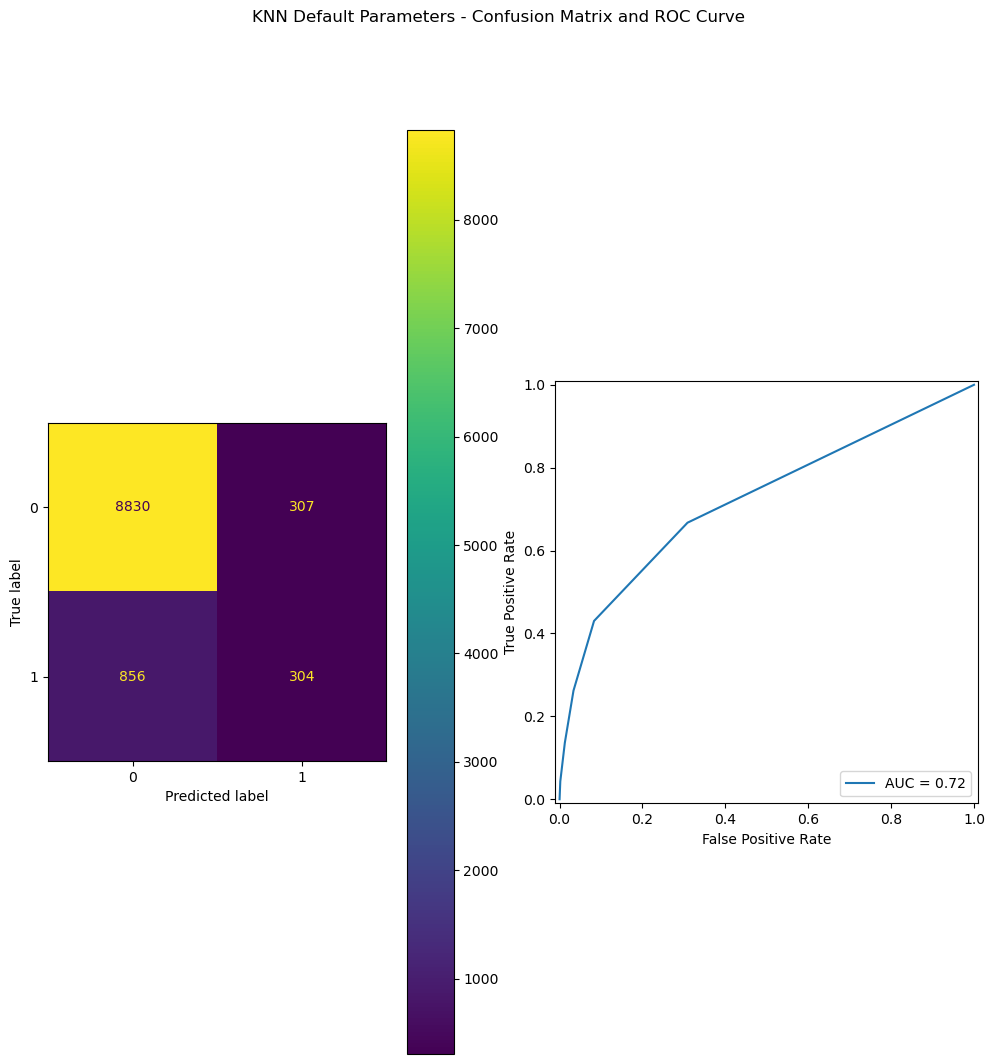

In [27]:
### KNN Default Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
knn_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = knnpipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = knnpipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
knn_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('KNN Default Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(knn_precision))
print('Accuracy ==> ' + str(accuracy))


In [28]:
# Using Decision Tree with default parameters
dtreepipe = ''
dtree_trainscore = ''
dtree_testscore = ''

dtreepipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('dtree', DecisionTreeClassifier())], verbose=True)
start_time = time.time()
dtreepipe.fit(X_train, y_train)
dtree_time = time.time() - start_time

print('Decision Tree Train Time (sec) ==> ' + str(dtree_time))

dtree_trainscore = dtreepipe.score(X_train, y_train)
print('Decision Tree Train Score ==> ' + str(dtree_trainscore))

dtree_testscore = dtreepipe.score(X_test, y_test)
print('Decision Tree Test Score ==> ' + str(dtree_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing dtree, total=   1.0s
Decision Tree Train Time (sec) ==> 2.1647019386291504
Decision Tree Train Score ==> 0.995047101097407
Decision Tree Test Score ==> 0.8380110711857822


False Positives ==> 885
False Negatives ==> 783
AUC ==> 0.62
Precision ==> 0.2987321711568938
Accuracy ==> 0.8380110711857822


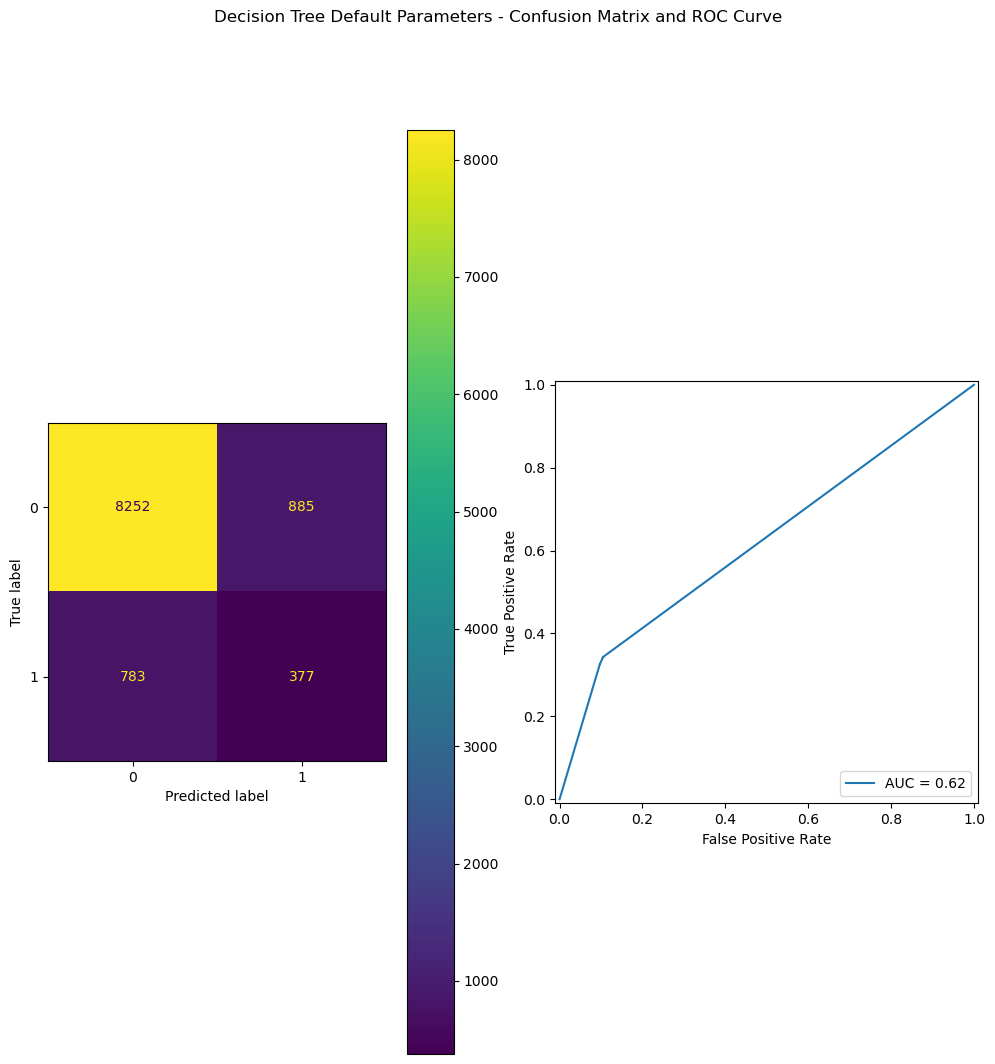

In [29]:
### DTree Default Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
dtree_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = dtreepipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = dtreepipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
dtree_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('Decision Tree Default Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(dtree_precision))
print('Accuracy ==> ' + str(accuracy))


In [30]:
# Using SVM with default parameters
svcpipe = ''
svc_trainscore = ''
svc_testscore = ''

svcpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('svc', SVC(probability=True))], verbose=True)
start_time = time.time()
svcpipe.fit(X_train, y_train)
svc_time = time.time() - start_time

print('SVM Train Time ==> ' + str(svc_time))

svc_trainscore = svcpipe.score(X_train, y_train)
print('SVM Train Score ==> ' + str(svc_trainscore))

svc_testscore = svcpipe.score(X_test, y_test)
print('SVM Test Score ==> ' + str(svc_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.0s
[Pipeline] ............... (step 3 of 3) Processing svc, total= 5.6min
SVM Train Time ==> 337.2515616416931
SVM Train Score ==> 0.9060567802919944
SVM Test Score ==> 0.9008449062833835


False Positives ==> 130
False Negatives ==> 891
AUC ==> 0.7
Precision ==> 0.6741854636591479
Accuracy ==> 0.9008449062833835


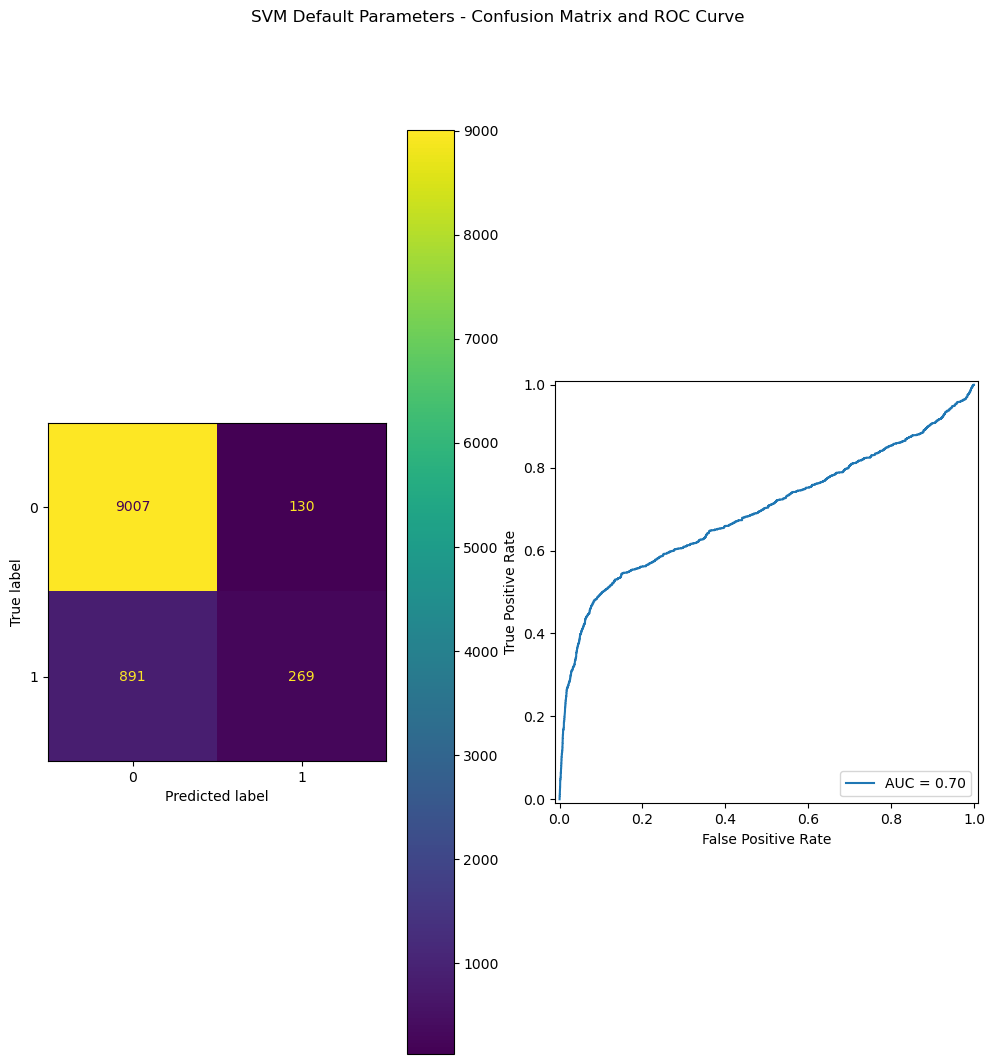

In [31]:
### SVM Default Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
svm_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = svcpipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = svcpipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
svm_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('SVM Default Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(svm_precision))
print('Accuracy ==> ' + str(accuracy))


In [32]:
#Create df to compare performance of different models
results_df = ''

res_dict = {'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
           'Train Accuracy': [lgr_pipe_trainscore, knnpipe_trainscore, dtree_trainscore, svc_trainscore],
           'Test Accuracy': [lgr_pipe_testscore, knnpipe_testscore, dtree_testscore, svc_testscore],
           'Test Precision': [lgr_precision, knn_precision, dtree_precision, svm_precision],
           'Average fit time (sec)': [lgr_time, knn_time, dtree_time, svc_time]}
results_df = pd.DataFrame(res_dict).set_index('Model')

results_df

,Train Accuracy,Test Accuracy,Test Precision,Average fit time (sec)
Model,,,,
Logistic Regression,0.900230,0.896475,0.623037,1.364163
KNN,0.914053,0.887054,0.497545,1.132433
Decision Tree,0.995047,0.838011,0.298732,2.164702
SVM,0.906057,0.900845,0.674185,337.251562


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

There's no gender feature in the data set.

In [33]:
# Tune KNN
warnings.filterwarnings('ignore')
knnpipe_grid = ''
knn_grid = ''
knn_best_n_neighbors = ''
knn_best_weights = ''

knnpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': list(range(3, 10, 2)),
          'knn__weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knnpipe_grid, param_grid=params)
knn_grid.fit(X_train, y_train)

# best parameters for KNN
knn_best_n_neighbors = knn_grid.best_params_['knn__n_neighbors']
knn_best_weights = knn_grid.best_params_['knn__weights']

print('Best n_neighbors ==> ' + str(knn_best_n_neighbors))
print('Best weights ==> ' + str(knn_best_weights))



Best n_neighbors ==> 3
Best weights ==> uniform


In [34]:
# Tune Logistic Regression
lgrpipe_grid = ''
lgr_grid = ''
lgr_best_c = ''
lgr_best_solver = ''

lgrpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression())])
params = {'lgr__C': [0.01, 0.1, 1, 10, 100],
          'lgr__solver': ['liblinear', 'lbfgs', 'sag', 'saga']}
lgr_grid = GridSearchCV(lgrpipe_grid, param_grid=params)
lgr_grid.fit(X_train, y_train)

# best parameters
lgr_best_c = lgr_grid.best_params_["lgr__C"]
lgr_best_solver = lgr_grid.best_params_["lgr__solver"]

print('LGR Best C ==> ' + str(lgr_best_c))
print('LGR Best Solver ==> ' + str(lgr_best_solver))



LGR Best C ==> 0.01
LGR Best Solver ==> liblinear


In [35]:
# Tune Decision Tree
dtreepipe_grid = ''
dtree_grid = ''
dtree_best_max_depth = ''
dtree_best_min_samples_leaf = ''
dtree_best_criterion = ''

dtreepipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('dtree', DecisionTreeClassifier())])
params = {'dtree__max_depth': list(range(5, 20)),
          'dtree__min_samples_leaf': list(range(2, 5)),
          'dtree__criterion': ['gini', 'entropy']}
dtree_grid = GridSearchCV(dtreepipe_grid, param_grid=params)
dtree_grid.fit(X_train, y_train)

# best parameters
dtree_best_max_depth = dtree_grid.best_params_["dtree__max_depth"]
dtree_best_min_samples_leaf = dtree_grid.best_params_["dtree__min_samples_leaf"]
dtree_best_criterion = dtree_grid.best_params_["dtree__criterion"]

print('Decision Tree Best Max Depth ==> ' + str(dtree_best_max_depth))
print('Decision Tree Best Min Samples Leaf ==> ' + str(dtree_best_min_samples_leaf))
print('Decision Tree Best Criterion ==> ' + str(dtree_best_criterion))




KeyboardInterrupt: 

In [ ]:
# Tune SVM
svcpipe_grid = ''
svc_grid = ''
svc_best_c = ''

svcpipe_grid = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('svc', SVC())])
params = {'svc__C': [0.1, 1]}
svc_grid = GridSearchCV(svcpipe_grid, param_grid=params)
svc_grid.fit(X_train, y_train)

# best parameters
svc_best_c = svc_grid.best_params_["svc__C"]

print('SVM Best C ==> ' + str(svc_best_c))


SVM Best C ==> 0.1


#### Using Best Parameters for each model

In [ ]:
# Using Logistic Regression with best parameters
lgr_pipe = ''
lgr_pipe_trainscore = ''
lgr_pipe_testscore = ''

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(C=lgr_best_c, solver=lgr_best_solver))], verbose=True)

start_time = time.time()
lgr_pipe.fit(X_train, y_train)
lgr_time = time.time() - start_time

print('LGR Train Time (sec) ==> ' + str(lgr_time))

# LGR train score
lgr_pipe_trainscore = lgr_pipe.score(X_train, y_train)

print('LGR Train Score ==> ' + str(lgr_pipe_trainscore))

# LGR test score
lgr_pipe_testscore = lgr_pipe.score(X_test, y_test)

print('LGR Test Score ==> ' + str(lgr_pipe_testscore))

[Pipeline] ....... (step 1 of 3) Processing transformer, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.1s
[Pipeline] ............... (step 3 of 3) Processing lgr, total=   0.1s
LGR Train Time (sec) ==> 1.259375810623169
LGR Train Score ==> 0.8994852869767893
LGR Test Score ==> 0.8952121977274935


False Positives ==> 132
False Negatives ==> 947
AUC ==> 0.77
Precision ==> 0.6173913043478261
Accuracy ==> 0.8952121977274935


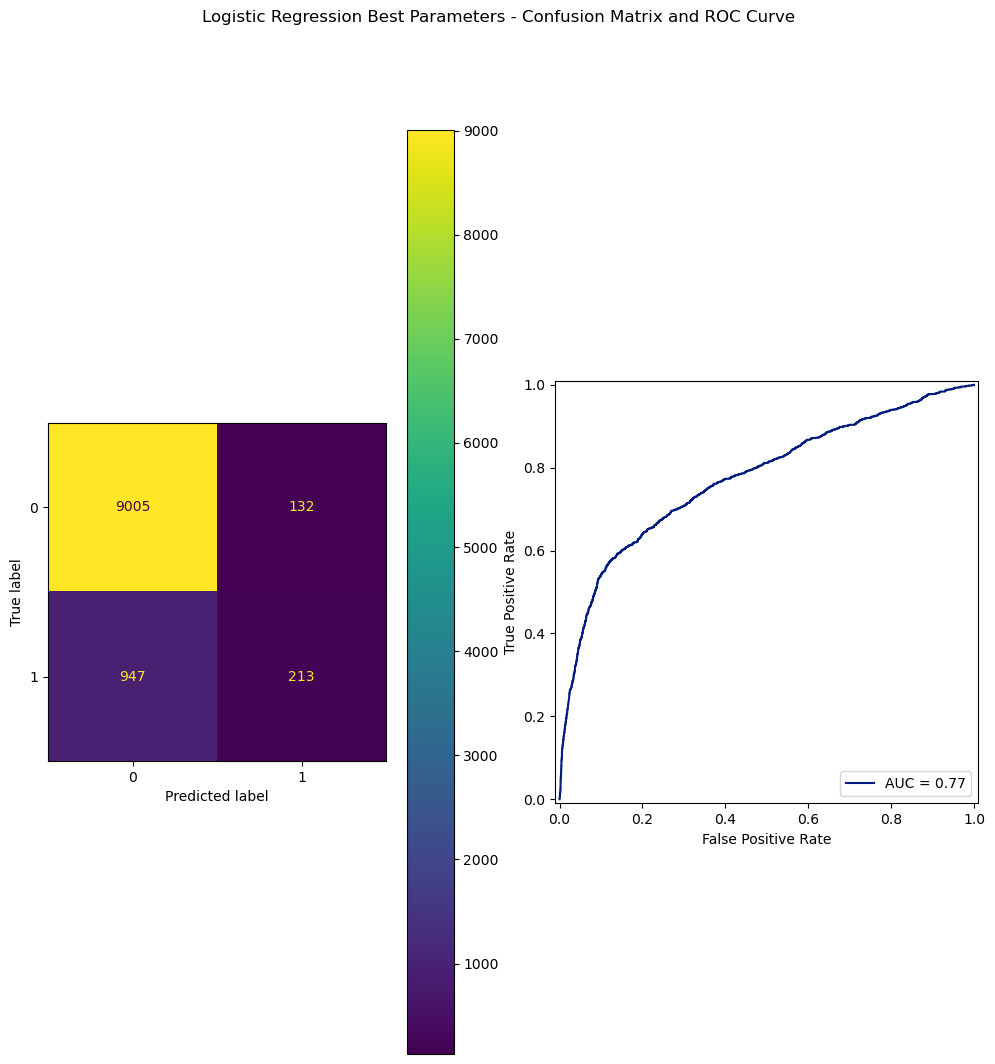

In [ ]:
### LGR Best Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
lgr_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = lgr_pipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
lgr_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('Logistic Regression Best Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(lgr_precision))
print('Accuracy ==> ' + str(accuracy))


In [ ]:
# Using KNN with best parameters
knnpipe = ''
knnpipe_trainscore = ''
knnpipe_testscore = ''

knnpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('knn', KNeighborsClassifier(n_neighbors=knn_best_n_neighbors, weights=knn_best_weights))], verbose=True)

start_time = time.time()
knnpipe.fit(X_train, y_train)
knn_time = time.time() - start_time

print('KNN Train Time (sec) ==> ' + str(knn_time))

knnpipe_trainscore = knnpipe.score(X_train, y_train)
print('KNN Train Score ==> ' + str(knnpipe_trainscore))

knnpipe_testscore = knnpipe.score(X_test, y_test)
print('KNN Test Score ==> ' + str(knnpipe_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.2s
[Pipeline] ............... (step 3 of 3) Processing knn, total=   0.0s
KNN Train Time (sec) ==> 1.354642391204834
KNN Train Score ==> 0.9249619630313036
KNN Test Score ==> 0.8825871613091192


False Positives ==> 378
False Negatives ==> 831
AUC ==> 0.7
Precision ==> 0.46534653465346537
Accuracy ==> 0.8825871613091192


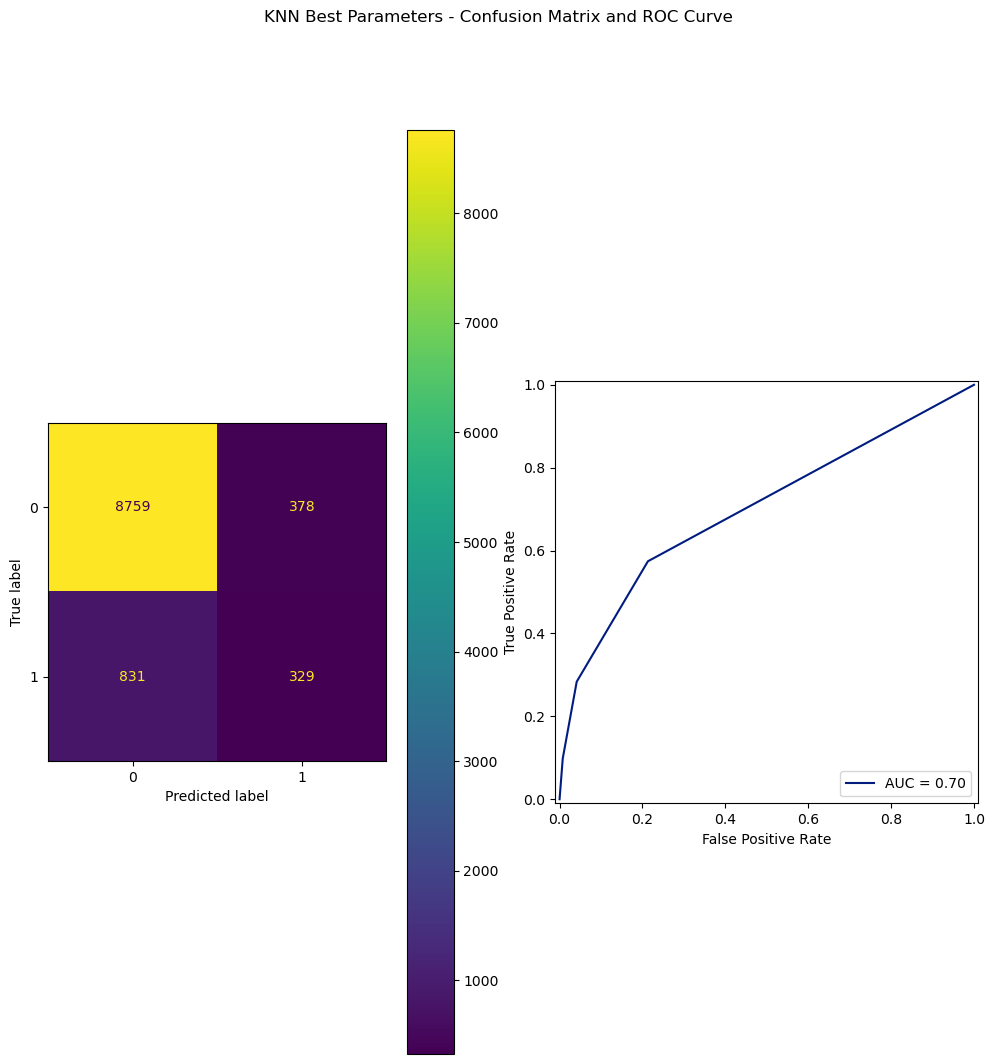

In [ ]:
### KNN Best Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
knn_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = knnpipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = knnpipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
knn_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('KNN Best Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(knn_precision))
print('Accuracy ==> ' + str(accuracy))


In [ ]:
# Using Decision Tree with best parameters
dtreepipe = ''
dtree_trainscore = ''
dtree_testscore = ''

dtreepipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('dtree', DecisionTreeClassifier(max_depth=dtree_best_max_depth, min_samples_leaf=dtree_best_min_samples_leaf, criterion=dtree_best_criterion))], verbose=True)
start_time = time.time()
dtreepipe.fit(X_train, y_train)
dtree_time = time.time() - start_time

print('Decision Tree Train Time (sec) ==> ' + str(dtree_time))

dtree_trainscore = dtreepipe.score(X_train, y_train)
print('Decision Tree Train Score ==> ' + str(dtree_trainscore))

dtree_testscore = dtreepipe.score(X_test, y_test)
print('Decision Tree Test Score ==> ' + str(dtree_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.2s
[Pipeline] ............. (step 3 of 3) Processing dtree, total=   0.1s
Decision Tree Train Time (sec) ==> 1.375014305114746
Decision Tree Train Score ==> 0.8873458288821987
Decision Tree Test Score ==> 0.8873458288821987


False Positives ==> 0
False Negatives ==> 1160
AUC ==> 0.69
Precision ==> nan
Accuracy ==> 0.8873458288821987


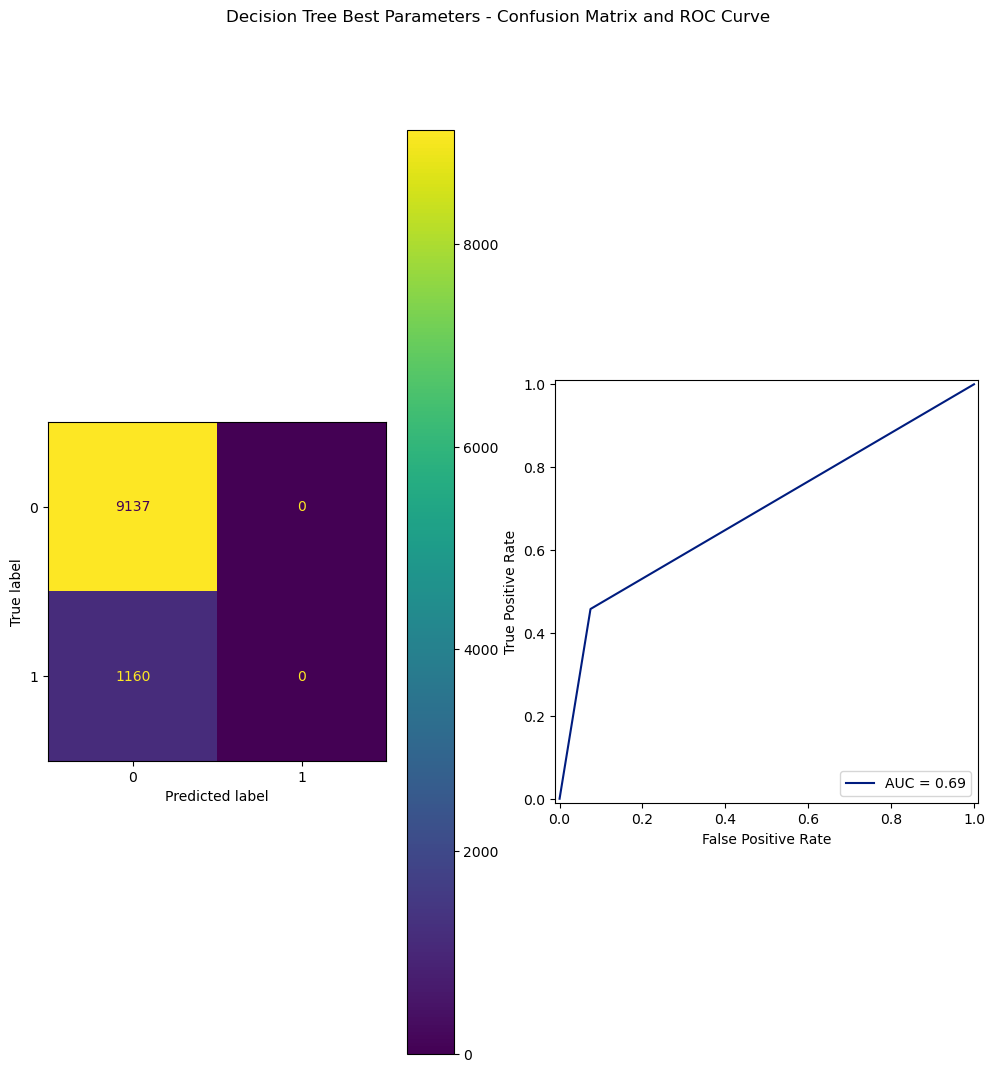

In [ ]:
### DTree Best Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
dtree_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = dtreepipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = dtreepipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
dtree_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('Decision Tree Best Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(dtree_precision))
print('Accuracy ==> ' + str(accuracy))


In [ ]:
# Using SVM with best parameters
svcpipe = ''
svc_trainscore = ''
svc_testscore = ''

svcpipe = Pipeline([('transform', transformer),
                    ('selector', extractor),
                    ('svc', SVC(probability=True, C=svc_best_c))], verbose=True)
start_time = time.time()
svcpipe.fit(X_train, y_train)
svc_time = time.time() - start_time

print('SVM Train Time ==> ' + str(svc_time))

svc_trainscore = svcpipe.score(X_train, y_train)
print('SVM Train Score ==> ' + str(svc_trainscore))

svc_testscore = svcpipe.score(X_test, y_test)
print('SVM Test Score ==> ' + str(svc_testscore))

[Pipeline] ......... (step 1 of 3) Processing transform, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   1.3s
[Pipeline] ............... (step 3 of 3) Processing svc, total= 3.2min
SVM Train Time ==> 191.02186751365662
SVM Train Score ==> 0.9001650966300865
SVM Test Score ==> 0.897154511022628


False Positives ==> 93
False Negatives ==> 966
AUC ==> 0.71
Precision ==> 0.6759581881533101
Accuracy ==> 0.897154511022628


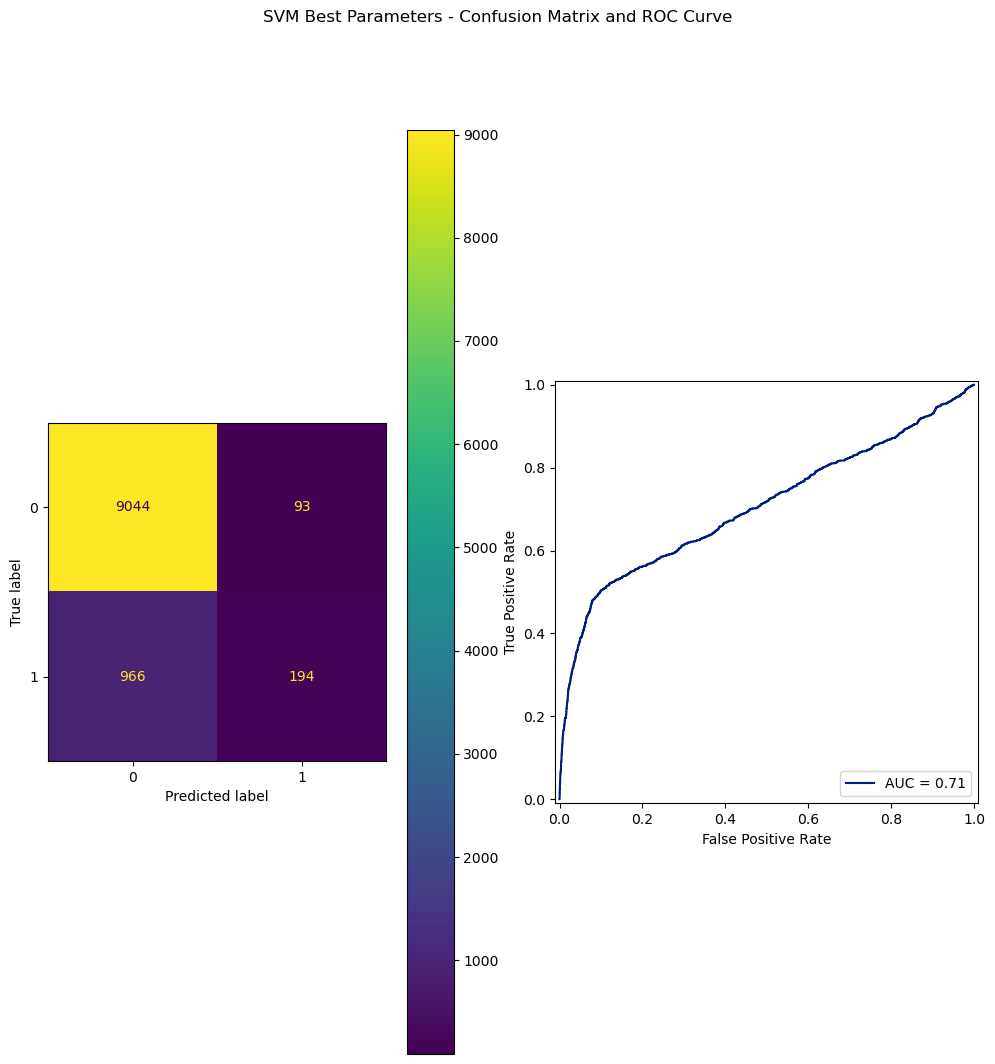

In [ ]:
### SVM Best Parameters - Confusion Matrix and ROC Curve

fp = ''
fn = ''
auc = ''
svm_precision = ''
accuracy = ''

from sklearn.metrics import auc as skl_auc

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

preds = svcpipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = svcpipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='yes')
roc_auc_value = skl_auc(fpr, tpr)

# precision and accuracy
svm_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0])


disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

# add title to figure
fig.suptitle('SVM Best Parameters - Confusion Matrix and ROC Curve')

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

print('False Positives ==> ' + str(fp))
print('False Negatives ==> ' + str(fn))
print('AUC ==> ' + str(auc))
print('Precision ==> ' + str(svm_precision))
print('Accuracy ==> ' + str(accuracy))


In [ ]:
#Create df to compare performance of different models using best parameters
results_df = ''

res_dict = {'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
           'Train Accuracy': [lgr_pipe_trainscore, knnpipe_trainscore, dtree_trainscore, svc_trainscore],
           'Test Accuracy': [lgr_pipe_testscore, knnpipe_testscore, dtree_testscore, svc_testscore],
           'Test Precision': [lgr_precision, knn_precision, dtree_precision, svm_precision],
           'Average fit time (sec)': [lgr_time, knn_time, dtree_time, svc_time]}
results_df = pd.DataFrame(res_dict).set_index('Model')

results_df

,Train Accuracy,Test Accuracy,Test Precision,Average fit time (sec)
Model,,,,
Logistic Regression,0.899485,0.895212,0.617391,1.259376
KNN,0.924962,0.882587,0.465347,1.354642
Decision Tree,0.887346,0.887346,0.465347,1.375014
SVM,0.900165,0.897155,0.675958,191.021868


##### Questions